<a href="https://colab.research.google.com/github/jeraldflowers/Semantic-Segmentation/blob/main/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reading and Viewing a Segmentation Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip '/content/drive/MyDrive/segmentation/segmentation.zip'

Archive:  /content/drive/MyDrive/segmentation/segmentation.zip
  inflating: 0016E5_07959.png        
  inflating: 0016E5_07959_L.png      
  inflating: 0016E5_07961.png        
  inflating: 0016E5_07961_L.png      
  inflating: 0016E5_07963.png        
  inflating: 0016E5_07963_L.png      
  inflating: 0016E5_07965.png        
  inflating: 0016E5_07965_L.png      
  inflating: 0016E5_07967.png        
  inflating: 0016E5_07967_L.png      
  inflating: 0016E5_07969.png        
  inflating: 0016E5_07969_L.png      
  inflating: 0016E5_07971.png        
  inflating: 0016E5_07971_L.png      
  inflating: 0016E5_07973.png        
  inflating: 0016E5_07973_L.png      
  inflating: 0016E5_07975.png        
  inflating: 0016E5_07975_L.png      
  inflating: 0016E5_07977.png        
  inflating: 0016E5_07977_L.png      
  inflating: 0016E5_07979.png        
  inflating: 0016E5_07979_L.png      
  inflating: 0016E5_07981.png        
  inflating: 0016E5_07981_L.png      
  inflating: 0016E5_07983

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

from sklearn.model_selection import train_test_split

In [5]:
dataset_path = './'
filenames = os.listdir(dataset_path)
filenames.sort()

image_list = []
masks_list = []

for filename in filenames:
  if len(filename.split('.')) > 1 and filename.split('.')[1][:3] == 'png':
    if filename.split('.')[0][-2:] == '_L':
      masks_list.append(dataset_path + '/' + filename)
    else:
      image_list.append(dataset_path + '/' + filename)

In [7]:
train_input_img_paths, val_input_img_paths, train_target_mask_paths, val_target_mask_paths = train_test_split(image_list, masks_list, test_size=0.2, random_state=42)

In [11]:
def load_data(images_path, masks_path):
  samples = {'images': [], 'masks': []}

  for i in range(len(images_path)):
    img = plt.imread(images_path[i])
    mask = plt.imread(masks_path[i])
    img = cv2.resize(img, (256,256))
    masks = cv2.resize(mask, (256,256))

    samples['images'].append(img)
    samples['masks'].append(masks)

  samples = {
      'images': np.array(samples['images']),
      'masks': np.array(samples['masks'])
  }

  return samples

In [13]:
train_samples = load_data(train_input_img_paths, train_target_mask_paths)
test_samples = load_data(val_input_img_paths, val_target_mask_paths) 

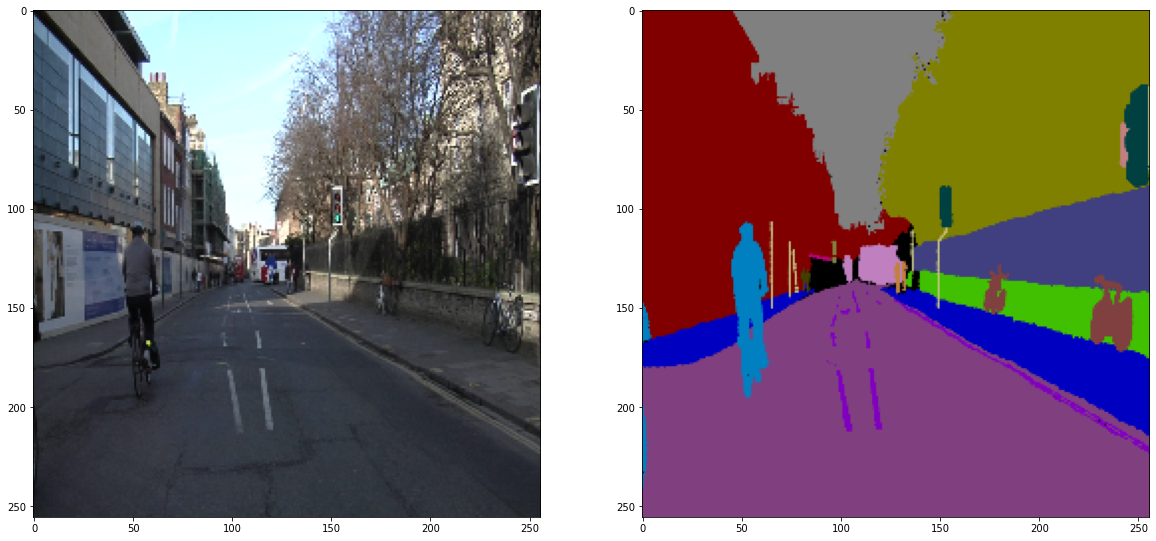

In [14]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(train_samples['images'][10])
plt.subplot(1,2,2)
plt.imshow(train_samples['masks'][10])
plt.show()


# 2. Creating a U-Net Network to Segmentation

In [16]:
def create_conv_block(input_tensor, num_filters):
  x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(input_tensor)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  return x

In [18]:
from IPython.utils.py3compat import PY2
def create_unet(input_shape, num_filters=16, dropout=0.1):
  # Encoder
  c1 = create_conv_block(input_shape, num_filters * 1)
  p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
  p1 = tf.keras.layers.Dropout(dropout)(p1)

  c2 = create_conv_block(p1, num_filters * 2)
  p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
  p2 = tf.keras.layers.Dropout(dropout)(p2)

  c3 = create_conv_block(p2, num_filters * 4)
  p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
  p3 = tf.keras.layers.Dropout(dropout)(p3)

  c4 = create_conv_block(p3, num_filters * 8)
  p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
  p4 = tf.keras.layers.Dropout(dropout)(p4)

  c5 = create_conv_block(p4, num_filters * 16)
  
  # Decoder
  u6 = tf.keras.layers.Convolution2DTranspose(num_filters*8, (3,3), strides=(2,2), padding='same')(c5)
  u6 = tf.keras.layers.concatenate([u6, c4])
  u6 = tf.keras.layers.Dropout(dropout)(u6)
  c6 = create_conv_block(u6, num_filters*8)

  u7 = tf.keras.layers.Convolution2DTranspose(num_filters*4, (3,3), strides=(2,2), padding='same')(c6)
  u7 = tf.keras.layers.concatenate([u7, c3])
  u7 = tf.keras.layers.Dropout(dropout)(u7)
  c7 = create_conv_block(u7, num_filters*4)

  u8 = tf.keras.layers.Convolution2DTranspose(num_filters*2, (3,3), strides=(2,2), padding='same')(c7)
  u8 = tf.keras.layers.concatenate([u8, c2])
  u8 = tf.keras.layers.Dropout(dropout)(u8)
  c8 = create_conv_block(u8, num_filters*2)

  u9 = tf.keras.layers.Convolution2DTranspose(num_filters*1, (3,3), strides=(2,2), padding='same')(c8)
  u9 = tf.keras.layers.concatenate([u9, c1])
  u9 = tf.keras.layers.Dropout(dropout)(u9)
  c9 = create_conv_block(u9, num_filters*1)


  output = tf.keras.layers.Conv2D(3, (1,1), activation='sigmoid')(c9)
  model = tf.keras.Model(inputs=[input_shape], outputs=[output])

  return model

In [19]:
inputs = tf.keras.layers.Input((256, 256, 3))
model = create_unet(inputs)

In [20]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

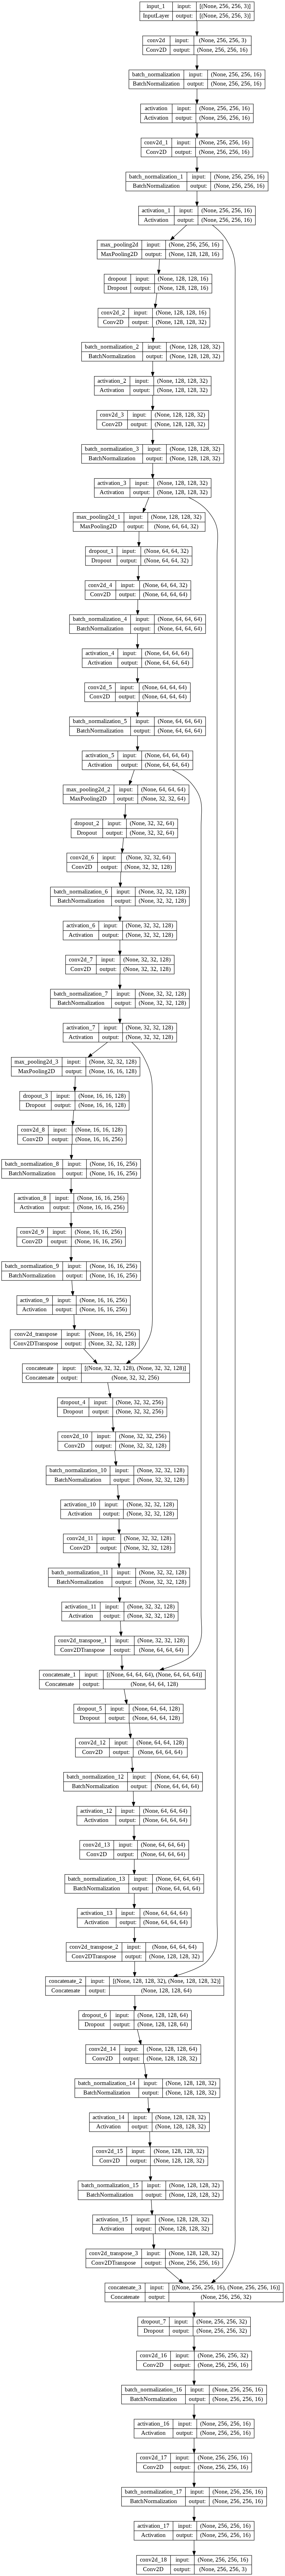

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [22]:
model_history = model.fit(train_samples['images'], train_samples['masks'], epochs=200, verbose=1)

Epoch 1/200
3/3 [==============================] - 20s 2s/step - loss: 0.7259 - accuracy: 0.1125
Epoch 2/200
3/3 [==============================] - 1s 306ms/step - loss: 0.6850 - accuracy: 0.1375
Epoch 3/200
3/3 [==============================] - 1s 304ms/step - loss: 0.6560 - accuracy: 0.1541
Epoch 4/200
3/3 [==============================] - 1s 307ms/step - loss: 0.6328 - accuracy: 0.1846
Epoch 5/200
3/3 [==============================] - 1s 301ms/step - loss: 0.6135 - accuracy: 0.2150
Epoch 6/200
3/3 [==============================] - 1s 304ms/step - loss: 0.5966 - accuracy: 0.2473
Epoch 7/200
3/3 [==============================] - 1s 306ms/step - loss: 0.5807 - accuracy: 0.3009
Epoch 8/200
3/3 [==============================] - 1s 303ms/step - loss: 0.5680 - accuracy: 0.3517
Epoch 9/200
3/3 [==============================] - 1s 305ms/step - loss: 0.5577 - accuracy: 0.3846
Epoch 10/200
3/3 [==============================] - 1s 307ms/step - loss: 0.5497 - accuracy: 0.4051
Epoch 11/20

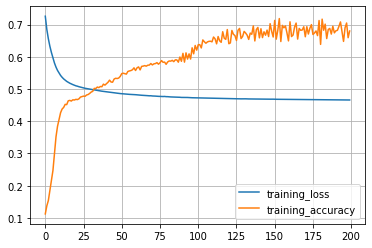

In [24]:
plt.plot(model_history.history['loss'], label='training_loss')
plt.plot(model_history.history['accuracy'], label='training_accuracy')
plt.legend()
plt.grid(True)
         

In [26]:
def predict_test_samples(val_map, model):
  img = val_map['images']
  mask = val_map['masks']

  test_images = np.array(img)

  predictions = model.predict(test_images)

  return predictions, test_images, mask

In [30]:
def plot_images(test_image, predicted_mask, ground_truth):
  plt.figure(figsize=(15,15))
  
  plt.subplot(1,3,1)
  plt.imshow(test_image)
  plt.title('Image')

  plt.subplot(1,3,2)
  plt.imshow(predicted_mask)
  plt.title('Predicted Mask')

  plt.subplot(1,3,3)
  plt.imshow(ground_truth)
  plt.title('Ground Truth Mask')

In [31]:
predicted_masks, test_images, ground_truth_mask = predict_test_samples(test_samples, model)

1/1 [==============================] - 0s 32ms/step


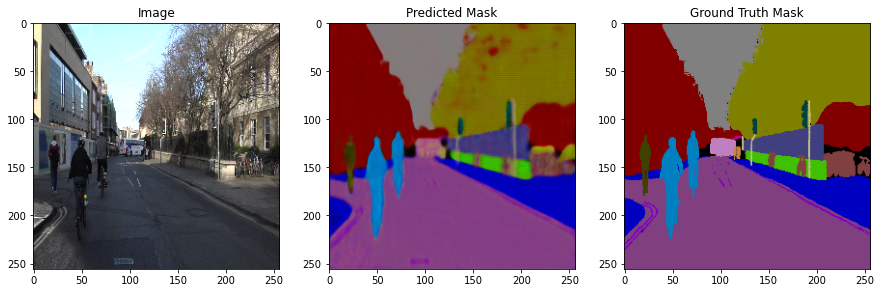

In [32]:
plot_images(test_images[20], predicted_masks[20], ground_truth_mask[20])